In [1]:
import numpy as np
import scipy.linalg as la

from qiskit import execute
from qiskit import Aer
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel

from racbem import *

import os
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/Users/flynn_chen/.pyxbld/temp.macosx-10.9-x86_64-3.7/pyrex/qutip/cy/openmp/parfuncs.cpp:636:10: fatal error: 'src/zspmv_openmp.hpp' file not found
#include "src/zspmv_openmp.hpp"
         ^~~~~~~~~~~~~~~~~~~~~~
1 error generated.


In [2]:
def GetBackend(backend_name=None):
    if backend_name == None:
        backend = Aer.get_backend('unitary_simulator')
        #backend = Aer.get_backend('qasm_simulator')
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
    return backend

To get consistent output:
1. remove random noise (sigma=0)
2. set seed = 0, and added seed in the build_random_circuit

In [3]:
backend_name = 'ibmq_burlington'
#backend_name = None
kappa = 5                   # condition number
n_sys_qubit = 3             # the number of system qubits
n_be_qubit = 1              # the number of block-encoding qubit
n_sig_qubit = 1             # the number of signal qubit
n_tot_qubit = n_sig_qubit+n_be_qubit+n_sys_qubit
n_depth = 15                # the depth of random circuit
prob_one_q_op = 0.5         # the probability of selecting a one-qubit
                            # operation when two_q_op is allowed
basis_gates = ['u1','u2','cx']
digit_shots = 13
n_shots = 2**digit_shots    # the number of shots used in measurements
sigma = 0                # parameter used to rescale noise model
# state |0^n>
b = np.zeros((2**n_sys_qubit,))
b[0] = 1.0
load_architecture = True    # True:     load architure locally
                            # False:    need to save an IBM account beforehand

In [4]:
np.random.rand(7) * np.pi

array([0.10366624, 0.29970329, 1.58804422, 2.47916832, 2.16000407,
       0.62399002, 1.80476491])

In [5]:
np.random.normal(7)

5.3849019212301155

In [6]:
phi_types = np.zeros((5, 7))

#zero rotation
phi_types[0, :] = np.zeros(7)

#sample from uniformly random
phi_types[1, :] = np.random.rand(7) * np.pi

#sample from gaussian random
phi_types[2, :] = np.random.normal(size=7) % np.pi

#sample from binomial random
phi_types[3, :] = np.random.binomial(10, 0.5, size=7) % np.pi

#sample from exponential random
phi_types[4, :] = np.random.exponential(size=7) % np.pi

print(phi_types)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.66415987 0.284528   0.56513036 1.89099108 1.93328034 2.83873939
  1.68019005]
 [2.1168516  2.70409087 1.54821904 1.3344308  2.05673286 0.58295665
  0.47120406]
 [2.85840735 2.85840735 2.85840735 1.85840735 0.71681469 1.85840735
  0.85840735]
 [0.20490664 0.10213751 1.44386006 0.87318786 0.85493832 2.26802222
  1.055138  ]]


In [7]:
for i in range(phi_types.shape[0]):
    seed = 0
    np.random.seed(seed)

    # instances of RACBEM
    be = BlockEncoding(n_be_qubit, n_sys_qubit)
    qsp = QSPCircuit(n_sig_qubit, n_be_qubit, n_sys_qubit)

    # retrieve backends and architectures
    backend = GetBackend()
    if load_architecture:
        if os.path.exists(backend_name+'_backend_config.pkl'):
            noise_backend = pickle.load(open(backend_name+'_backend_config.pkl','rb'))
            noise_model = NoiseModel.from_dict(noise_backend['noise_dict'])
            coupling_map = noise_backend['coupling_map']
            tot_q_device = noise_backend['tot_q_device']
            print("\nload architecture locally at: %s_backend_config.pkl\n"%(backend_name))
        else:
            raise Exception("no locally saved architecture: %s_backend_config.pkl"%(backend_name), load_architecture)
    else:
        noise_backend = GetBackend(backend_name=backend_name)
        coupling_map = noise_backend.configuration().coupling_map
        noise_model = NoiseModel.from_backend(noise_backend)
        tot_q_device = noise_backend.configuration().n_qubits
        pickle.dump({'noise_dict': noise_model.to_dict(), 'coupling_map': coupling_map, 'tot_q_device': tot_q_device, 
                    'basis_gates': noise_backend.configuration().basis_gates}, open(backend_name+'_backend_config.pkl','wb'))
        print("retrieve architecture from IBM Q and save locally at: %s_backend_config.pkl\n"%(backend_name))
    assert tot_q_device >= n_tot_qubit
    new_noise_model = scale_noise_model(noise_model, sigma)

    # exclude qubit 0 as signal qubit, shift the remaining labels by -1
    be_map = [[q[0]-1,q[1]-1] for q in coupling_map if (0 not in q) and 
            (q[0] < n_tot_qubit) and (q[1] < n_tot_qubit)]
    be.build_random_circuit(n_depth, basis_gates=basis_gates, 
            prob_one_q_op=prob_one_q_op, coupling_map=be_map, seed=seed)
    be.build_dag()

    # load phase factors
    data = np.loadtxt("phi_inv_%d.txt"%(kappa))
    #phi_seq = data[:-2]
    phi_seq = phi_types[i, :]
    scale_fac = data[-2]
    app_err = data[-1]

    # retrieve block-encoded matrix
    UA = retrieve_unitary_matrix(be.qc)
    A = UA[0:2**n_sys_qubit, 0:2**n_sys_qubit]
    (svd_U, svd_S, svd_VH) = la.svd(A)

    # succ prob via measurement
    qsp.build_circuit(be.qc, be.qc_dag, phi_seq, realpart=True, measure=False)
    compiled_circ = qsp.qcircuit
    job = execute(compiled_circ, backend=backend, shots=n_shots, seed_transpiler=seed, seed_simulator=seed)
    job_monitor(job)
    result = job.result()
    
    transformed_U = result.get_unitary(compiled_circ, decimals=3)
    transformed_A = transformed_U[0:2**n_sys_qubit, 0:2**n_sys_qubit]
    (transformed_svd_U, transformed_svd_S, transformed_svd_VH) = la.svd(transformed_A)
    
    print("singular value (A) = \n", np.around(svd_S, decimals=3))
    print("transformed singular value (A) = \n", np.around(transformed_svd_S, decimals=3))
    #print(A)
    #print(transformed_A)
    
    poly_fit_val = np.polynomial.chebyshev.Chebyshev.fit(svd_S, transformed_svd_S, 2, full=True)
    print(poly_fit_val)


load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [1. 1. 1. 1. 1. 1. 1. 1.]
(Chebyshev([1.00000000e+00, 6.24241581e-17, 4.07892395e-16], domain=[0.47682494, 0.89259179], window=[-1.,  1.]), [array([1.98246473e-31]), 3, array([1.34640729, 0.95626786, 0.52224437]), 1.7763568394002505e-15])

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.788 0.776 0.775 0.746 0.666 0.665 0.66  0.646]
(Chebyshev([ 0.72521551,  0.06250947, -0.00625187], domain=[0.47682494, 0.89259179], window=[-1.,  1.]), [array([0.00065652]), 3, array([1.34640729, 0.95626786, 0.52224437]), 1.7763568394002505e-15])

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has 

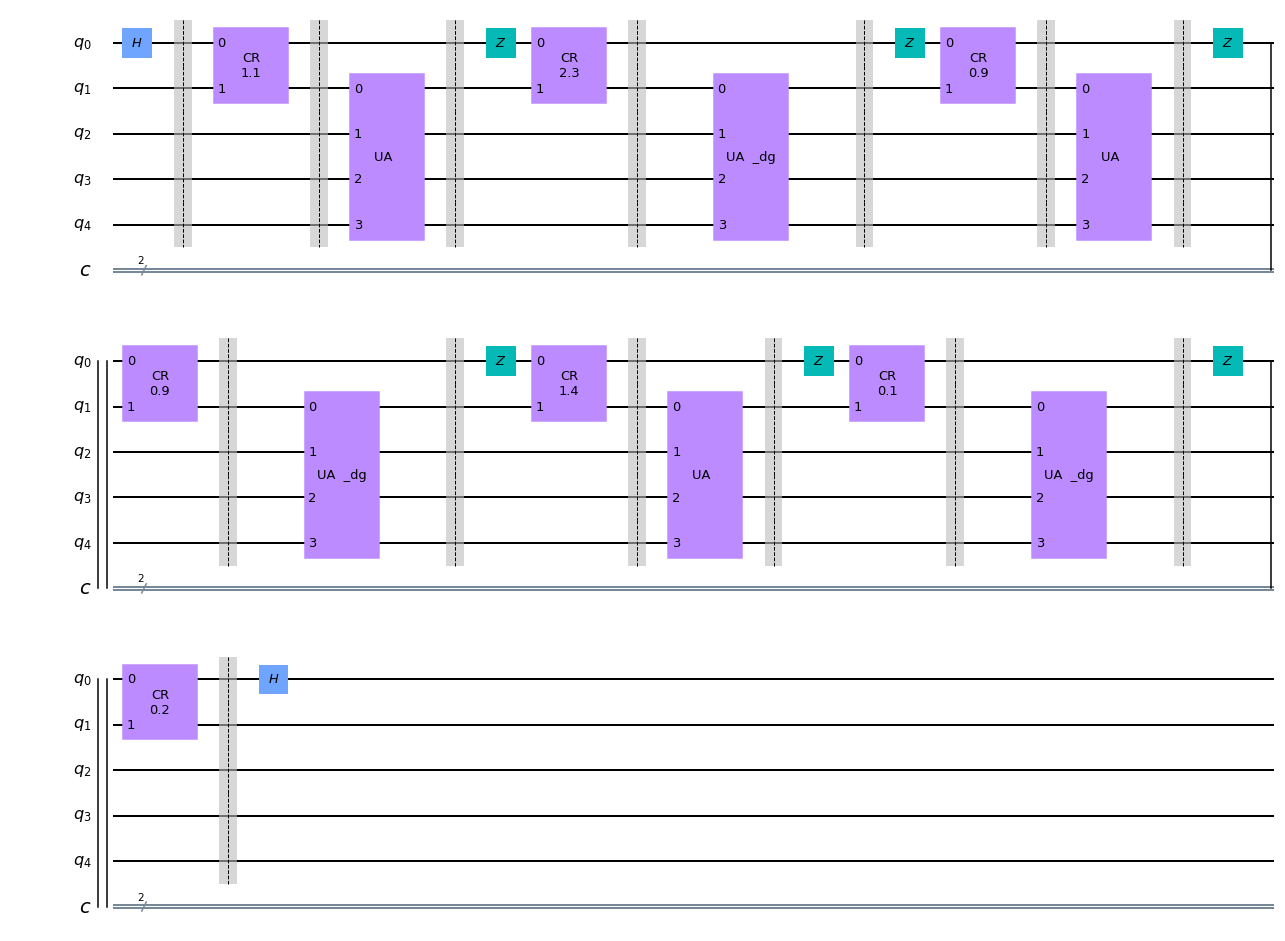

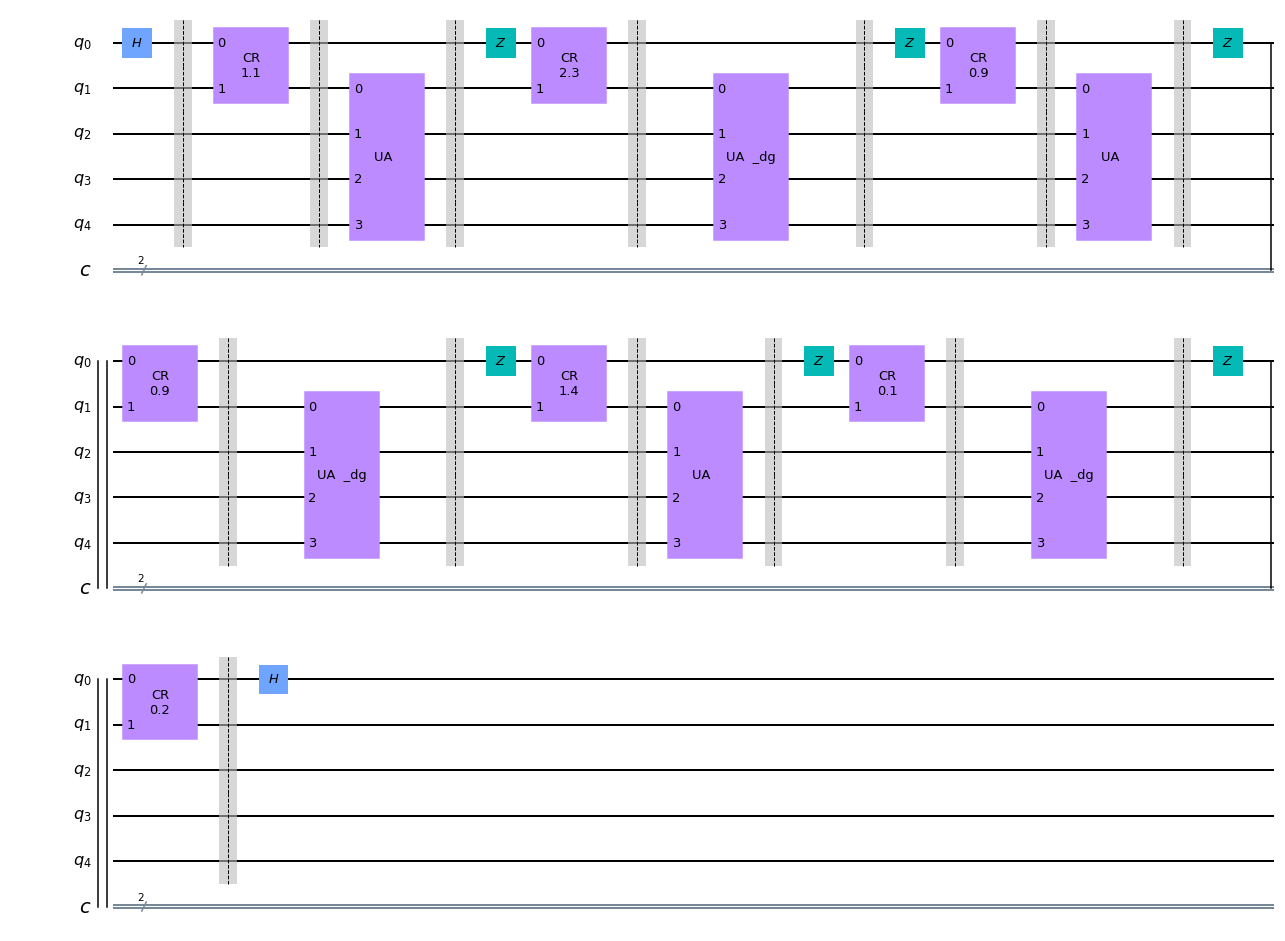

In [8]:
qsp.qcircuit.draw(output='mpl')